# Reddit Depression Detection

Improvements
1. Autocorrect
2. Spell Check
3. Grammar Check

## Initialization

### Import Statements


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

### Import Dataset

In [2]:
df = pd.read_csv('dataset.csv')
df.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


### Dataset Transformation

In [3]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df['class'] = df['class'].replace({'suicide':1,'non-suicide':0})
df.head()

C:\Users\Rishabh\AppData\Local\Temp\ipykernel_14500\3534510445.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['class'] = df['class'].replace({'suicide':1,'non-suicide':0})


,text,class
0,Ex Wife Threatening SuicideRecently I left my ...,1
1,Am I weird I don't get affected by compliments...,0
2,Finally 2020 is almost over... So I can never ...,0
3,i need helpjust help me im crying so hard,1
4,"I’m so lostHello, my name is Adam (16) and I’v...",1


### Balanced Sampling

In [4]:
df = pd.concat([df[df['class']==1].head(16000), df[df['class']==0].tail(16000)],ignore_index=True)
# df[df['class']=='non-suicide'].tail(5000)

### Check Dimensions

In [5]:
df.shape

(32000, 2)

### Label Counts

In [6]:
df['class'].value_counts()

class
1    16000
0    16000
Name: count, dtype: int64

##### Balanced Dataset

### Remove Null/Duplicated Values

In [7]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df.shape

(32000, 2)

## Preprocessing

### Demojification and Tag Removal

Removal of Hyperlinks, Emojis and r/ tokens

In [8]:
import re
df['text'] = [re.sub(r"[^a-z A-Z 0-9 \,\.!@#$%^&*_\(\)-=+\{\}\[\]:;'<>/?|`]", '', str(sentence)) for sentence in df['text']]    # Removes Emojis
df['text'] = [re.sub(r"https?://\S+", '', str(sentence)) for sentence in df['text']]                                            # Removes Hyperlinks
df['text'] = [re.sub(r"\br/\S+", '', str(sentence)) for sentence in df['text']]                                                 # Removes r/ Reddit Communities

### Lemmatization and Lowering

In [9]:
# python -m spacy download en_core_web_sm
import spacy
nlp = spacy.load('en_core_web_sm', disable=['ner','parser'])

# 5m 31s execution time
def preprocess(sentence):
    doc = nlp(sentence)
    lemmatized_tokens = [token.lemma_.lower() for token in doc if token.pos_ != 'PUNCT' and not token.is_stop]
    return ' '.join(token for token in lemmatized_tokens).strip()

# 3m 12s execution time
def batch_preprocess(sentences):
    lemmatized_texts = (' '.join(token.lemma_.lower() for token in doc if token.pos_ != 'PUNCT' and not token.is_stop).strip() for doc in nlp.pipe(sentences, batch_size=500, disable=['parser', 'ner'], n_process=2))
    return lemmatized_texts

df['text_lemma'] = list(batch_preprocess(df['text'].tolist()))

C:\Users\Rishabh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Model Building

### TF-IDF Vectorizing

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords

vectorizer = TfidfVectorizer(max_features=12000, stop_words=stopwords.words('english'), ngram_range=(1,2))
X_train, X_test, Y_train, Y_test = train_test_split(df['text_lemma'], df['class'], test_size=0.2, random_state=42)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

### Model Training

#### XGBoost

In [11]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
model = XGBClassifier()
model.fit(X_train_vectorized, Y_train)
Y_pred = model.predict(X_test_vectorized)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.89      0.92      0.91      3126
           1       0.93      0.89      0.91      3274

    accuracy                           0.91      6400
   macro avg       0.91      0.91      0.91      6400
weighted avg       0.91      0.91      0.91      6400



#### Random Forest Classifier

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
model = RandomForestClassifier()
model.fit(X_train_vectorized, Y_train)
Y_pred = model.predict(X_test_vectorized)
accuracy_score(Y_test, Y_pred)

0.89296875

#### Logistic Regression

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
model = LogisticRegression(solver='liblinear')
model.fit(X_train_vectorized, Y_train)
Y_pred = model.predict(X_test_vectorized)
accuracy_score(Y_test, Y_pred)

0.92296875

In [14]:
X_train_vectorized.shape

(25600, 12000)

### Deep Learning - ANN

Early stopping mechanism for optimality of epochs

In [15]:
from keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True, verbose=1, mode='auto', min_delta=0.00001, baseline=None)

Mini-Batch Gradient Descent with Optimised Loss and Maximal Accuracy

In [39]:
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Dropout
model = Sequential()
model.add(Dense(128, input_dim=X_train_vectorized.shape[1], activation='sigmoid'))
model.add(Dropout(0.4))
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
hist = model.fit(X_train_vectorized.toarray(), Y_train, epochs=20, validation_split=0.2,callbacks=callback, batch_size=64)

Epoch 1/20
320/320 [==============================] - 10s 27ms/step - loss: 0.5560 - accuracy: 0.7101 - val_loss: 0.2951 - val_accuracy: 0.8928
Epoch 2/20
320/320 [==============================] - 8s 24ms/step - loss: 0.2325 - accuracy: 0.9134 - val_loss: 0.2145 - val_accuracy: 0.9164
Epoch 3/20
320/320 [==============================] - 8s 24ms/step - loss: 0.1687 - accuracy: 0.9392 - val_loss: 0.2055 - val_accuracy: 0.9184
Epoch 4/20
320/320 [==============================] - 8s 24ms/step - loss: 0.1348 - accuracy: 0.9523 - val_loss: 0.2075 - val_accuracy: 0.9182
Epoch 4: early stopping


### Model Accuracy

In [40]:
Y_prob = model.predict(X_test_vectorized.toarray())
Y_pred = np.where(Y_prob>0.5, 1, 0)
model.evaluate(X_test_vectorized.toarray(), Y_test)

200/200 [==============================] - 1s 3ms/step - loss: 0.1985 - accuracy: 0.9248


[0.19850695133209229, 0.9248437285423279]

### Accuracy Plots

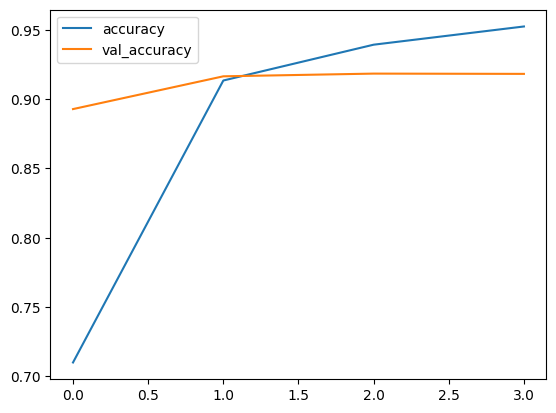

In [41]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'],loc='best')
plt.show()

### Loss Plots

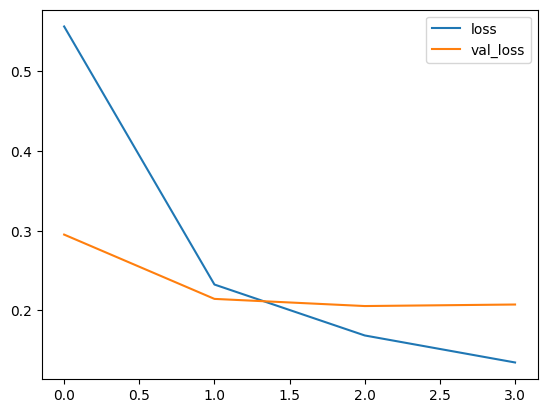

In [42]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['loss', 'val_loss'],loc='best')
plt.show()

### Confusion Matrix

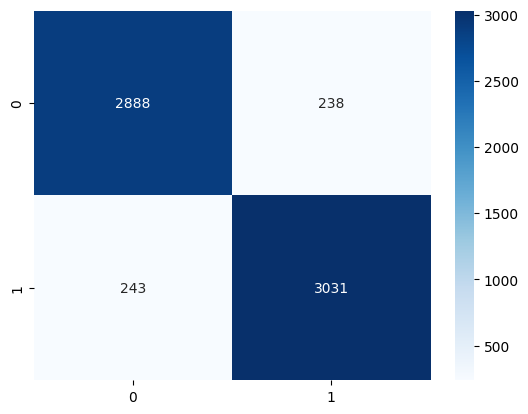

In [43]:
from tensorflow import math
cm = math.confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()

### User Input

In [44]:
input1 = input("Enter expression to check depression: ")
input1 = preprocess(input1)
input_vectorized = vectorizer.transform([input1])
pred = model.predict(input_vectorized.toarray())
if np.where(pred>0.5,1,0)==1:
    print("Depressed")
else:
    print("Not Depressed")

1/1 [==============================] - 0s 84ms/step
Not Depressed


### Summary of ANN Model

In [45]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 128)               1536128   
                                                                 
 dense_14 (Dense)            (None, 64)                8256      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 1)                 65        
                                                                 
Total params: 1544449 (5.89 MB)
Trainable params: 1544449 (5.89 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
